# **Data Mining en Ciencia y Tecnología: Pre-Tp 1**

Autor: Ricardo Amarilla

Fecha: 20-04-2025

Comisión: 2


# ***Importamos librerias***

In [ ]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Parámetros de visualización
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (8, 6)


import os

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx

from glob import glob
from pathlib import Path

# ***Los datos***

Bajamos y revisamos el dataset

Utilizar el signo de exclamación permite correr comandos como si fuera la terminal de la computadora. Podemos utilizarlo para descargar (wget) o descomprimir (unzip) archivos, y también para instalar librerías de python (pip install) entre otras.

In [ ]:
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
!unzip -q DataSujetos
!wget -q -O aal_extended_withCoords.csv https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1

### Atlas
Son 116 regiones cerebrales
La columna "1" indica el nombre de la subregión, la columna "3" indica a qué región cerebral pertenece, la columna "4" en qué hemisferio se localiza (L=izquierda, R=derecham, --= está en la línea media), las columnas "5", "6" y "7" indican las coordenadas x, y, z de cada subregión

In [ ]:
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

## Lista de archivos
Tenemos varios sujetos para 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):<br>

"W": despierto ("Wake")
<br> "N1": sueño "leve"
<br>"N2": sueño "intermedio"
<br>"N3": sueño "profundo"

In [ ]:
files = os.listdir('DataSujetos/')

Obtener archivos correspondientes a la condición "W" unicamente:

In [ ]:
filenames = Path('DataSujetos').glob('W_*.csv')
next(filenames)

PosixPath('DataSujetos/W_suj12.csv')

# ***Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia pesada") para el sujeto 2 de la condición despierto ("Wake")***

In [ ]:
filename = '/content/DataSujetos/W_suj2.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaT = df.values
n = matAdyacPesadaT.shape[0]
matAdyacPesadaT -= np.diag(np.ones(n))

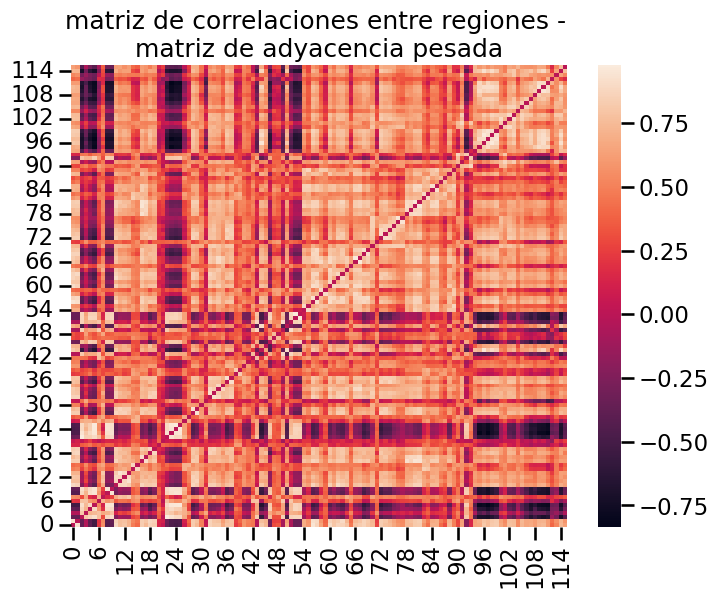

In [ ]:
sns.heatmap(matAdyacPesadaT)
plt.xlim(0, n)
plt.ylim(0, n)
plt.title(f'matriz de correlaciones entre regiones - \nmatriz de adyacencia pesada')
plt.show()

# ***Transformar dicha matriz de adyacencia pesada a una matriz de adyacencia binaria Ai,j que represente una densidad de enlaces δ=0.08. ¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?***

In [ ]:
def density_to_th(W, d):
    n = W.shape[0]
    tril_idx = np.tril_indices(n, -1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

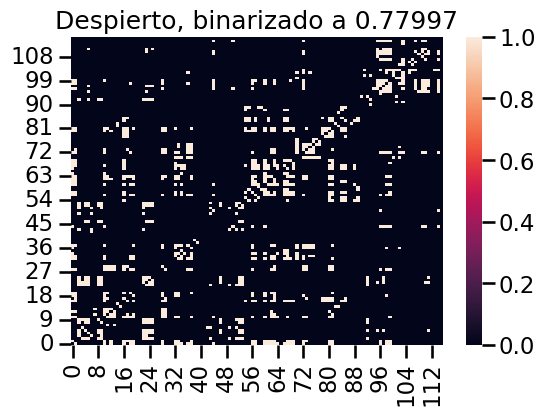

In [ ]:
densidad=0.08

plt.figure(figsize=(6, 4))

thWake = density_to_th(matAdyacPesadaT, densidad)

matAdyacNoPesadaT = np.abs(matAdyacPesadaT) >= thWake # Binarizamos utilizando una condicion booleana
# Recordemos que 1 es equivalente a True y 0 a False en Python

sns.heatmap(matAdyacNoPesadaT)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Despierto, binarizado a {thWake}')
plt.show()

# ***Utilizando Ai,j , obtener el grafo resultante G***

In [ ]:
G = nx.from_numpy_array(matAdyacNoPesadaT)


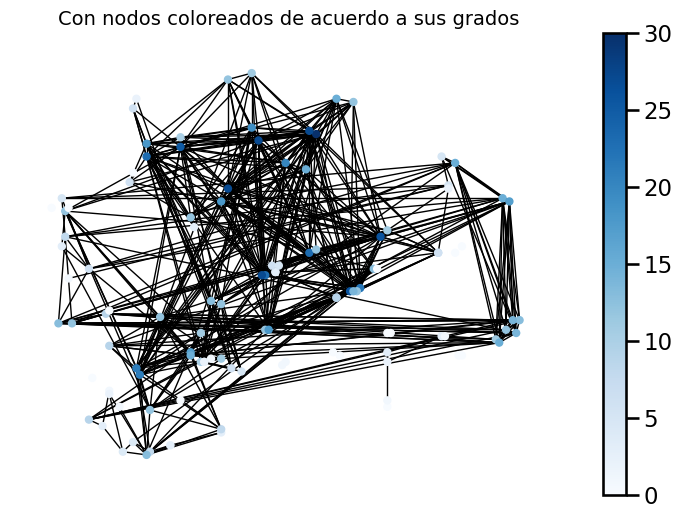

In [ ]:
degrees = G.degree
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

layout = dict(zip(range(n), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(n_color)
vmax = max(n_color)
cmap = plt.cm.Blues
norm = plt.Normalize(vmin = vmin, vmax=vmax)

plt.figure(figsize=(9,6))
plt.title('Con nodos coloreados de acuerdo a sus grados', fontsize=14)
nx.draw(G, layout, linewidths=1, node_size=25, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()

# ***¿Es G un grafo conectado?***

In [ ]:
print('Es conectado?:', nx.is_connected(G))

Es conectado?: False


## ***¿Se puede calcular la distancia media entre pares de nodos del grafo G?***

In [ ]:
if nx.is_connected(G):
  avg_dist = nx.average_shortest_path_length(G)
  print(f"Longitud promedio del grafo G es igual a : {avg_dist}")
else:
  print("El grafo no está conectado.")
  #Es necesario tomar el componente gigante.
  componente_gigante_mp = max(nx.connected_components(G), key = len)
  componente_gigante = G.subgraph(componente_gigante_mp).copy()
  av_dist_cg = nx.average_shortest_path_length(componente_gigante)
  print(f"Longitud promedio del componente gigante de G es igual a : {av_dist_cg}")

El grafo no está conectado.
Longitud promedio del componente gigante de G es igual a : 3.1168179646440515


## ***¿Si no se puede, qué medida equivalente calcularías?***

In [ ]:
print("Existen dos posibilidades por un lado calcular la Eficiencia Global o Calcular la <d> del componente gigante")

Existen dos posibilidades por un lado calcular la Eficiencia Global o Calcular la <d> del componente gigante


## ***Calcular d para cada componente conectado de G. Calcular la eficiencia global eff del grafo G.***

In [ ]:
d = dict(nx.all_pairs_all_shortest_paths(G))

def eficiencia_global(G):
    n = len(G)
    if n < 2:
        return 0

    suma_inversas = 0
    for origen, destinos in nx.all_pairs_shortest_path_length(G):
        for destino, distancia in destinos.items():
            if origen != destino:
                suma_inversas += 1 / distancia  # suma de 1/d(i,j)

    eficiencia = suma_inversas / (n * (n - 1))
    return eficiencia

eg = eficiencia_global(G)
print("Eficiencia global del grafo:", eg)


Eficiencia global del grafo: 0.264875597915335


In [ ]:
import networkx as nx

# Suponé que ya tenés tu grafo G
componentes = list(nx.connected_components(G))

for i, comp in enumerate(componentes):
    subgrafo = G.subgraph(comp)
    n = subgrafo.number_of_nodes()

    if n > 1:
        d = nx.average_shortest_path_length(subgrafo)
        print(f"Componente {i+1} (nodos: {n}): distancia promedio d = {d:.3f}")
    else:
        print(f"Componente {i+1} (nodo aislado): no se puede calcular distancia promedio")


Componente 1 (nodos: 92): distancia promedio d = 3.117
Componente 2 (nodos: 5): distancia promedio d = 1.600
Componente 3 (nodo aislado): no se puede calcular distancia promedio
Componente 4 (nodo aislado): no se puede calcular distancia promedio
Componente 5 (nodo aislado): no se puede calcular distancia promedio
Componente 6 (nodo aislado): no se puede calcular distancia promedio
Componente 7 (nodo aislado): no se puede calcular distancia promedio
Componente 8 (nodo aislado): no se puede calcular distancia promedio
Componente 9 (nodos: 2): distancia promedio d = 1.000
Componente 10 (nodo aislado): no se puede calcular distancia promedio
Componente 11 (nodo aislado): no se puede calcular distancia promedio
Componente 12 (nodo aislado): no se puede calcular distancia promedio
Componente 13 (nodo aislado): no se puede calcular distancia promedio
Componente 14 (nodo aislado): no se puede calcular distancia promedio
Componente 15 (nodo aislado): no se puede calcular distancia promedio
Com

# ***Calcular el grado promedio < k >, el nodo con grado máximo kmax , el coeficiente de clustering promedio C =< Ci >***

In [ ]:
avg_degree = 2*G.number_of_edges()/G.number_of_nodes()
print(f"El grado promedio <k> es igual a {avg_degree}")

El grado promedio <k> es igual a 9.379310344827585


In [ ]:
grados = pd.DataFrame(G.degree, columns=['Node','Degree']).set_index('Node')
kmax_valor = grados['Degree'].max()
kmax_nodo = grados['Degree'].idxmax()
print(f"El nodo con grado máximo es el : {kmax_nodo}, y el kmáx is igual a : {kmax_valor}")

El nodo con grado máximo es el : 0, y el kmáx is igual a : 30


In [ ]:
avg_clus = nx.average_clustering(G)

print(f"El el coeficiente de clustering promedio <Ci> es igual a {avg_clus}")

El el coeficiente de clustering promedio <Ci> es igual a 0.5131233170907938


# ***Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de clustering Ci***

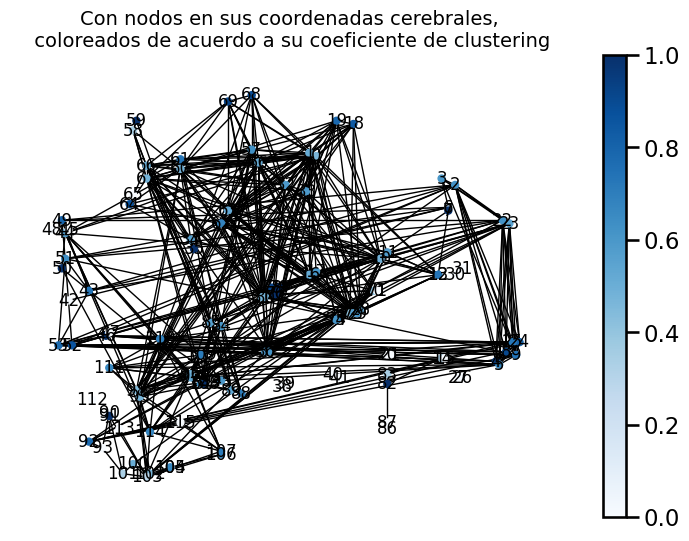

In [ ]:
clustering = nx.clustering(G)
nodes = G.nodes()
n_color = np.asarray([clustering[n] for n in nodes])

layout = dict(zip(range(n), np.array([RegionsNames[6].values, RegionsNames[7].values]).T))
vmin = min(n_color)
vmax = max(n_color)
cmap = plt.cm.Blues
norm = plt.Normalize(vmin = vmin, vmax=vmax)

plt.figure(figsize=(9,6))
plt.title('Con nodos en sus coordenadas cerebrales,\n coloreados de acuerdo a su coeficiente de clustering', fontsize=14)
nx.draw(G, layout, with_labels=True, linewidths=1, node_size=25, node_color=n_color, vmin=vmin, vmax=vmax,cmap=cmap)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, ax=plt.gca())
plt.show()



# ***Graficar la distribución de grado del grafo (el histograma normalizado, eligiendo un número de bins apropriado).***

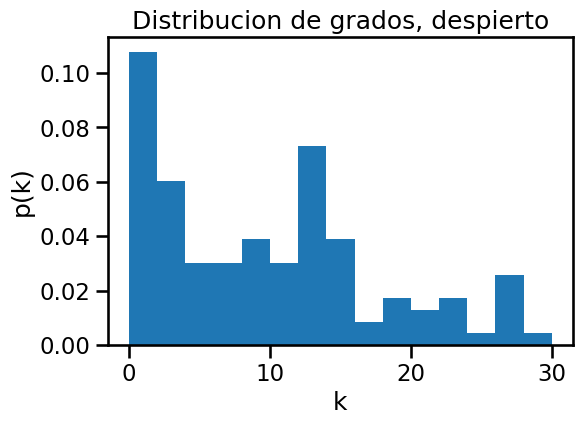

In [ ]:
plt.figure(figsize=(6, 4))
Gwake = nx.from_numpy_array(matAdyacNoPesadaT)
degreesWake = [Gwake.degree(n) for n in Gwake.nodes()]
histWake, binsWake, _ = plt.hist(degreesWake, bins=15, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

plt.show()

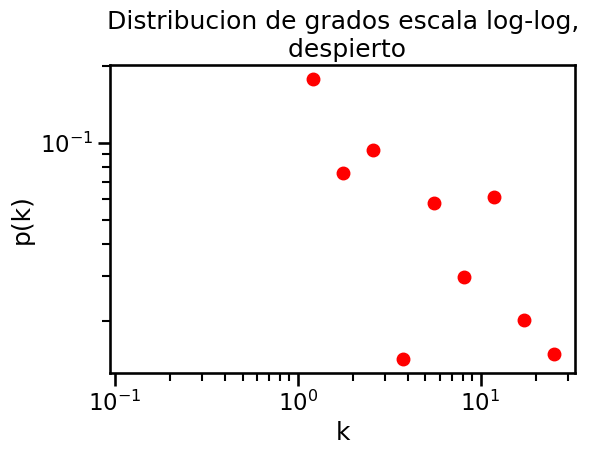

In [ ]:
plt.figure(figsize=(6, 4))
logbinsWake = np.logspace(np.log10(binsWake[0]+.1), np.log10(binsWake[-1]+.1), len(binsWake))
histWakeLog, logbinsWake, _ = plt.hist(degreesWake, bins=logbinsWake, density=True, log=True)
plt.clf()
x = (logbinsWake[:-1] + logbinsWake[1:]) / 2
plt.plot(x, histWakeLog,'ro')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribucion de grados escala log-log,\n despierto')

plt.show()

# ***Comparemos dos estados de vigila***

In [ ]:
filename = '/content/DataSujetos/W_suj2.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaWake = df.values
n = matAdyacPesadaWake.shape[0]
matAdyacPesadaWake -= np.diag(np.ones(n))

filename = '/content/DataSujetos/N3_suj2.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesadaSleep = df.values
n = matAdyacPesadaSleep.shape[0]
matAdyacPesadaSleep -= np.diag(np.ones(n))

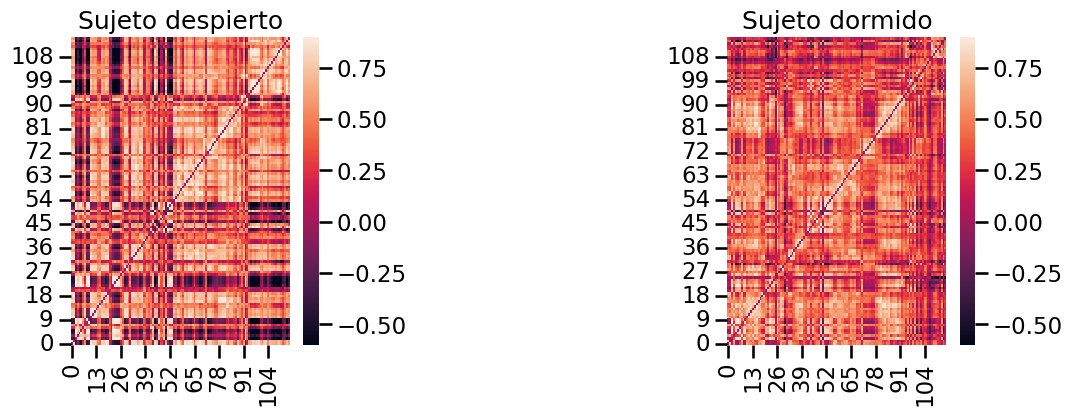

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(131)
sns.heatmap(matAdyacPesadaWake, vmin=-.6, vmax=.9)
plt.xlim(0, n)
plt.ylim(0, n)
plt.title('Sujeto despierto')

plt.subplot(133)
sns.heatmap(matAdyacPesadaSleep, vmin=-.6, vmax=.9)
plt.xlim(0, n)
plt.ylim(0, n)
plt.title('Sujeto dormido')

plt.show()

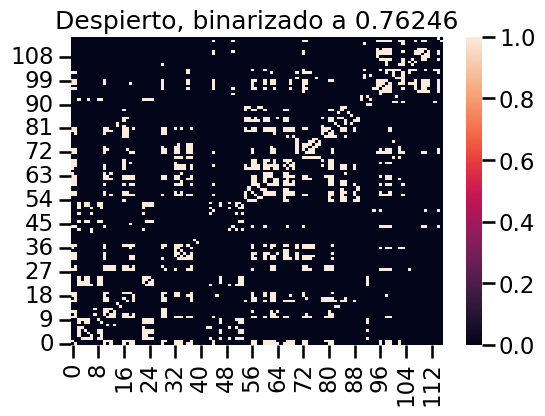

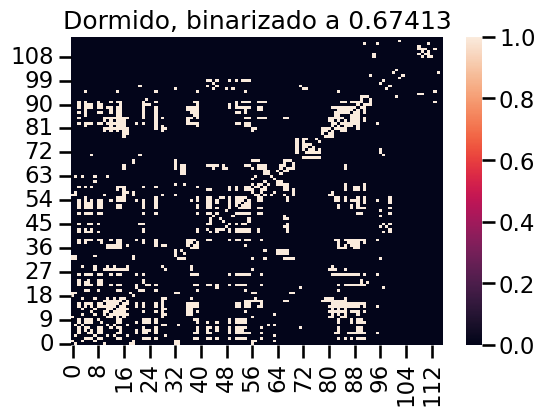

In [ ]:
densidad=0.1 # comparemos ambos estados con una densidad de enlaces de 10%

plt.figure(figsize=(6, 4))

thWake = density_to_th(matAdyacPesadaWake, densidad)
sns.heatmap(matAdyacPesadaWake >= thWake)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Despierto, binarizado a {thWake}')
plt.show()

plt.figure(figsize=(6,4))
thSleep = density_to_th(matAdyacPesadaSleep, densidad)
sns.heatmap(matAdyacPesadaSleep >= thSleep)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Dormido, binarizado a {thSleep}')

plt.show()

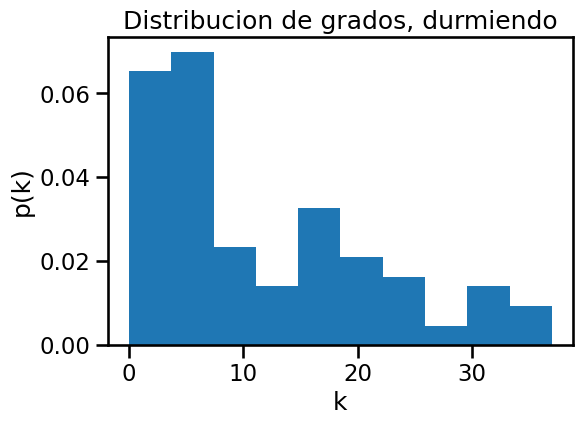

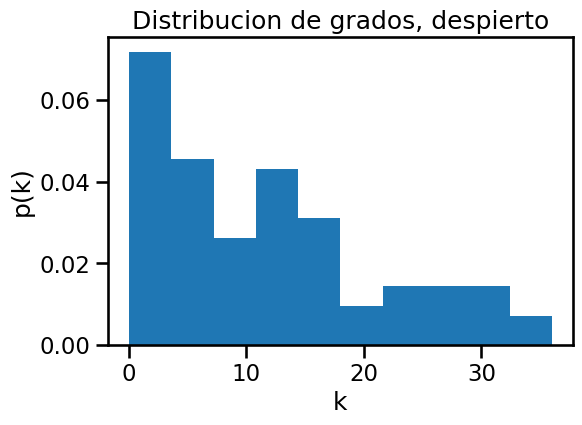

In [ ]:
plt.figure(figsize=(6, 4))
Gsleep = nx.from_numpy_array(matAdyacPesadaSleep >= thSleep)
degreesSleep = [Gsleep.degree(n) for n in Gsleep.nodes()]
histSleep, binsSleep, _ = plt.hist(degreesSleep, bins=10, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, durmiendo')


plt.figure(figsize=(6, 4))
Gwake = nx.from_numpy_array(matAdyacPesadaWake >= thWake)
degreesWake = [Gwake.degree(n) for n in Gwake.nodes()]
histWake, binsWake, _ = plt.hist(degreesWake, bins=10, density=True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

plt.show()

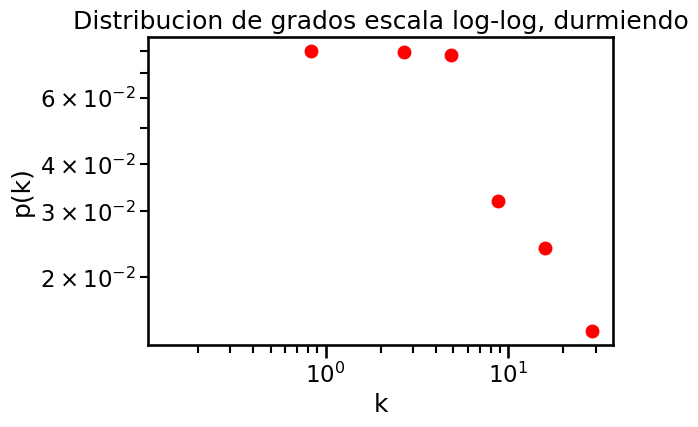

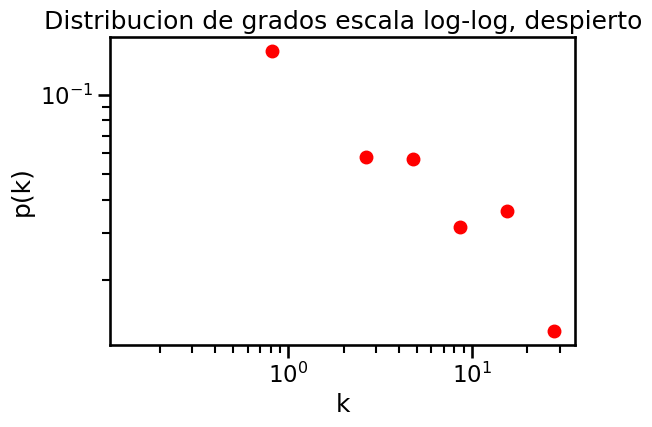

In [ ]:
plt.figure(figsize=(6, 4))
logbinsSleep = np.logspace(np.log10(binsSleep[0]+.1), np.log10(binsSleep[-1]+.1), len(binsSleep))
histSleepLog, logbinsSleep, _ = plt.hist(degreesSleep, bins=logbinsSleep, density=True, log=True)
plt.clf()
x = (logbinsSleep[:-1] + logbinsSleep[1:]) / 2
plt.plot(x,histSleepLog,'ro')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribucion de grados escala log-log, durmiendo')

plt.figure(figsize=(6, 4))
logbinsWake = np.logspace(np.log10(binsWake[0]+.1), np.log10(binsWake[-1]+.1), len(binsWake))
histWakeLog, logbinsWake, _ = plt.hist(degreesWake, bins=logbinsWake, density=True, log=True)
plt.clf()
x = (logbinsWake[:-1] + logbinsWake[1:]) / 2
plt.plot(x, histWakeLog,'ro')
plt.xlabel('k')
plt.ylabel('p(k)')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribucion de grados escala log-log, despierto')

plt.show()